### 1 - Imports and Initial Configurations

In [44]:
import pandas as pd
import numpy as np
from scipy.stats import entropy
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
import yaml

# Visualization settings for the plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['font.size'] = 12

### 2 - Definition of the Simulated Environment (Pools, Rules, Costs, Weights)

In [23]:
# Defining the content pools and conditional rules for the "after" state
with open("../Ambient Data/enemies_and_events.yaml", "r", encoding="utf-8") as file:
    enemies_and_events_data = yaml.safe_load(file)

POOLS = enemies_and_events_data["pools"]
RULES = enemies_and_events_data["conditional_rules"]

# Load equipment catalog data
with open("../Ambient Data/equipment_catalog.yaml", "r", encoding="utf-8") as file:
    equipment_catalog_data = yaml.safe_load(file)

EQUIPMENT_CATALOG = equipment_catalog_data["equipment_catalog"]

# import copy
# POOLS_AFTER = copy.deepcopy(POOLS_BEFORE)
# #POOLS_AFTER['enemies']['Bedrose Gardener'] = {'cost': 10, 'weight': 65, 'tags': ['Common']}

# CONDITIONAL_RULES_AFTER = copy.deepcopy(CONDITIONAL_RULES_BEFORE)
# # New synergy rule for the added content
# # CONDITIONAL_RULES_AFTER.append(
    
# # )

### 3 - Implementation of the Content Generation Function

In [24]:
def draw_item(pool, current_budget, tag_context, rules):
    valid_items = []
    adjusted_weights = []

    for name, attributes in pool.items():
        if attributes['cost'] <= current_budget:
            final_weight = attributes['weight']
            # Apply conditional rules
            for rule in rules:
                if rule['if_tag'] in tag_context and rule['then_tag'] in attributes['tags']:
                    final_weight *= rule['multiplier']
            
            valid_items.append(name)
            adjusted_weights.append(final_weight)

    if not valid_items:        
        return 'None', pool['None']

    # Normalize the weights to create a probability distribution
    weight_sum = sum(adjusted_weights)
    probabilities = [p / weight_sum for p in adjusted_weights]

    # Draw an item based on the adjusted weights
    choice = np.random.choice(valid_items, p=probabilities)
    return choice, pool[choice]


def generate_room_content(k, pools, rules, T='standard'):
    # Initial budget increases with depth k
    initial_budget = 10 + k * 2.5
    
    tag_context = set()
    result = {}

    # 1. Draw Enemy
    enemy_name, enemy = draw_item(pools['enemies'], initial_budget, tag_context, rules)
    result['enemy'] = enemy_name
    tag_context.update(enemy['tags'])
    remaining_budget_1 = initial_budget - enemy['cost']

    # 2. Draw Event
    event_name, event = draw_item(pools['events'], remaining_budget_1, tag_context, rules)
    result['event'] = event_name
    tag_context.update(event['tags'])
    remaining_budget_2 = remaining_budget_1 - event['cost']

    # 3. Draw Effect
    effect_name, effect = draw_item(pools['room_effects'], remaining_budget_2, tag_context, rules)
    result['effect'] = effect_name
    
    result['total_cost'] = (enemy['cost'] + event['cost'] + effect['cost'])
    return result

### 4 - Implementation of the Simulation Function

In [20]:
def run_simulation(pools, rules, n_simulations=10000):
    data = []
    for k_sim in range(1, 11):
        for _ in range(n_simulations // 10):
            room = generate_room_content(k=k_sim, T='standard', pools=pools, rules=rules)
            room['k'] = k_sim
            data.append(room)
    return pd.DataFrame(data)

### 5 - Simulation Before and After the New Addition

In [21]:
print("Starting simulations...")
df_before = run_simulation(POOLS_BEFORE, CONDITIONAL_RULES_BEFORE)
print("'BEFORE' simulation complete.")
df_after = run_simulation(POOLS_AFTER, CONDITIONAL_RULES_AFTER)
print("'AFTER' simulation complete.")

Starting simulations...
'BEFORE' simulation complete.
'AFTER' simulation complete.


### 6 - Analysis and Visualization Functions

In [22]:
def analyze_frequency(df_before, df_after, column):
    fig, axes = plt.subplots(1, 2, figsize=(18, 7), sharey=True)
    
    df_before[column].value_counts(normalize=True).plot(kind='bar', ax=axes[0], color='skyblue')
    axes[0].set_title(f'Frequency Distribution (BEFORE) - {column}')
    axes[0].set_ylabel('Relative Frequency')
    
    df_after[column].value_counts(normalize=True).plot(kind='bar', ax=axes[1], color='salmon')
    axes[1].set_title(f'Frequency Distribution (AFTER) - {column}')
    
    plt.suptitle(f'Frequency Analysis for Category: {column.upper()}', fontsize=16)
    plt.show()

def analyze_cost(df_before, df_after):
    plt.figure(figsize=(12, 7))
    sns.kdeplot(df_before['total_cost'], label='BEFORE', color='skyblue', fill=True)
    sns.kdeplot(df_after['total_cost'], label='AFTER', color='salmon', fill=True)
    plt.title('Distribution of Total Cost per Room (Difficulty)')
    plt.xlabel('Total Cost')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

def analyze_cooccurrence(df, title):
    cooc = pd.crosstab(df['enemy'], df['effect'])
    plt.figure(figsize=(10, 8))
    sns.heatmap(cooc, annot=True, fmt='d', cmap='viridis')
    plt.title(f'Enemy x Effect Co-occurrence Matrix ({title})')
    plt.show()

def calculate_info_metrics(df, col1, col2):
    # Marginal Entropy H(X)
    p_x = df[col1].value_counts(normalize=True)
    h_x = entropy(p_x, base=2)

    # Marginal Entropy H(Y)
    p_y = df[col2].value_counts(normalize=True)
    h_y = entropy(p_y, base=2)

    # Joint Entropy H(X, Y)
    p_xy = df.groupby([col1, col2]).size() / len(df)
    h_xy = entropy(p_xy, base=2)

    # Mutual Information I(X; Y) = H(X) + H(Y) - H(X,Y)
    i_xy = h_x + h_y - h_xy

    return {'H(col1)': h_x, 'H(col2)': h_y, 'H(col1,col2)': h_xy, 'I(col1;col2)': i_xy}


### 7 - Analysis of the Generator Function After the Addition

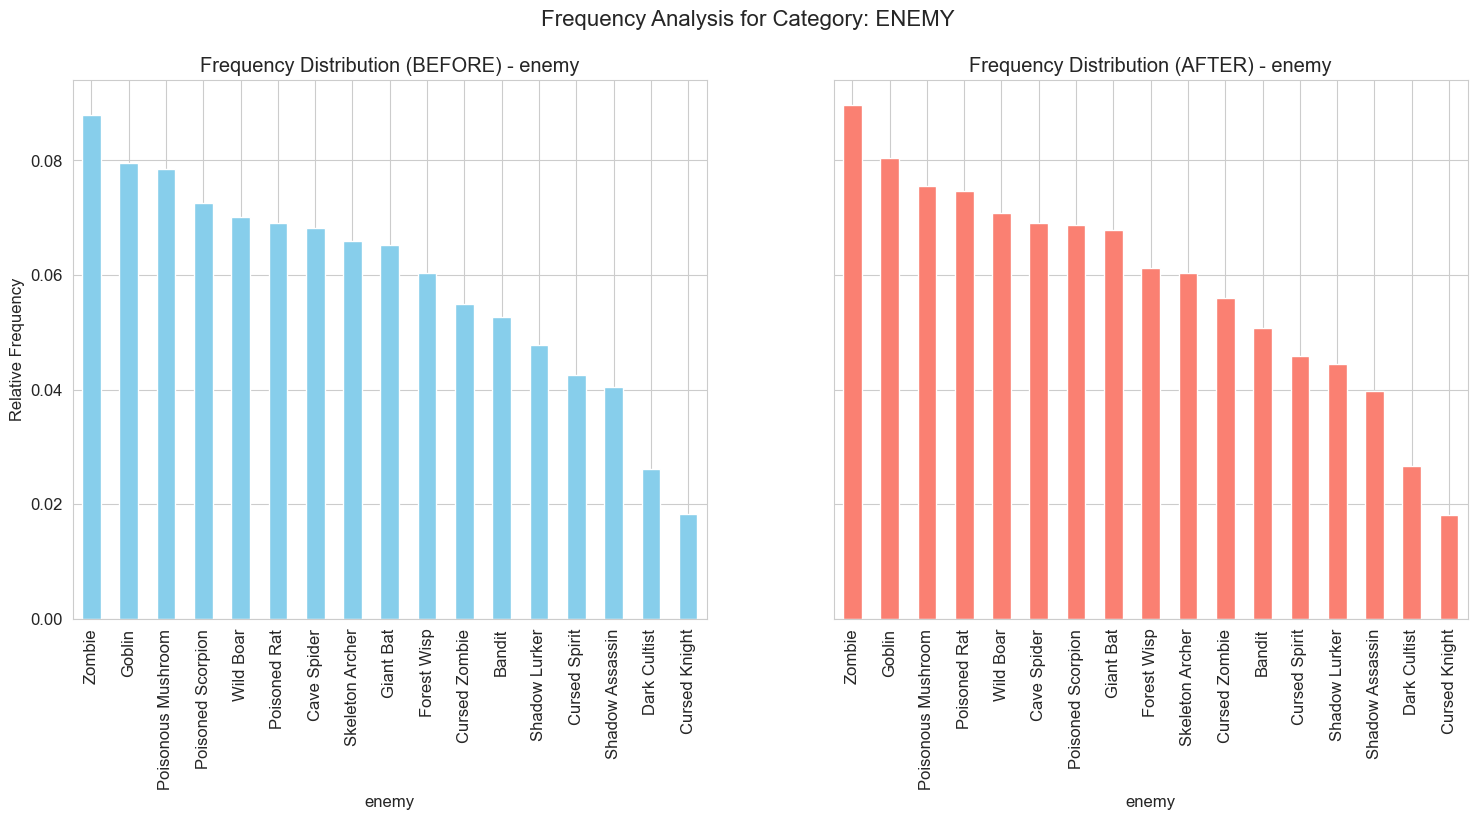

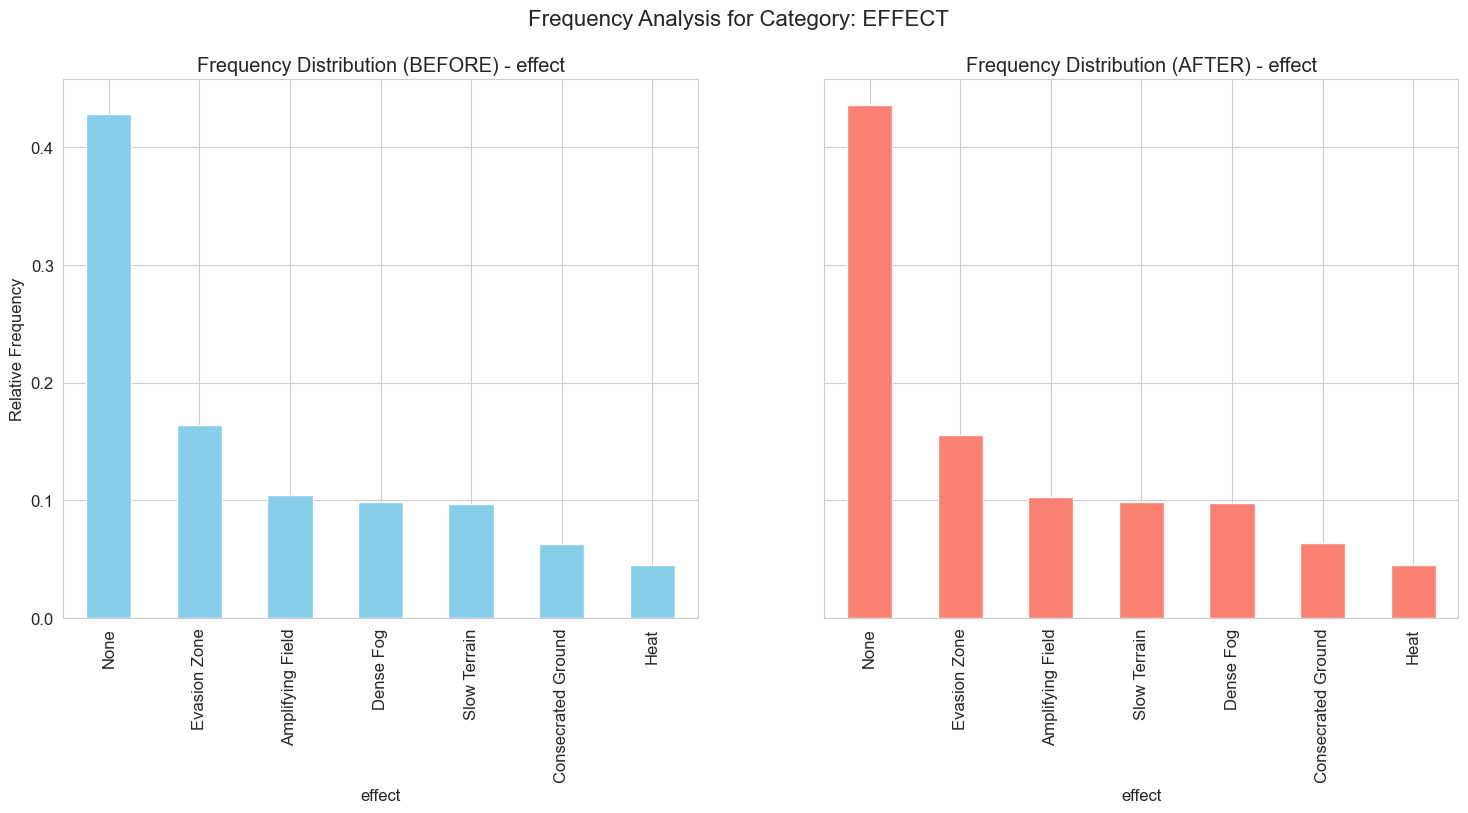

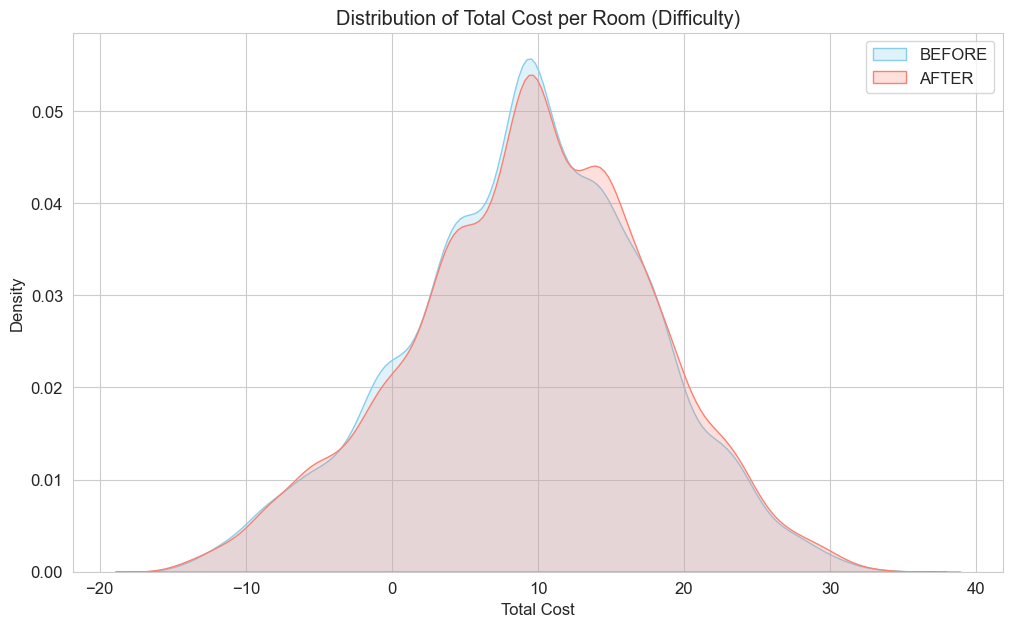

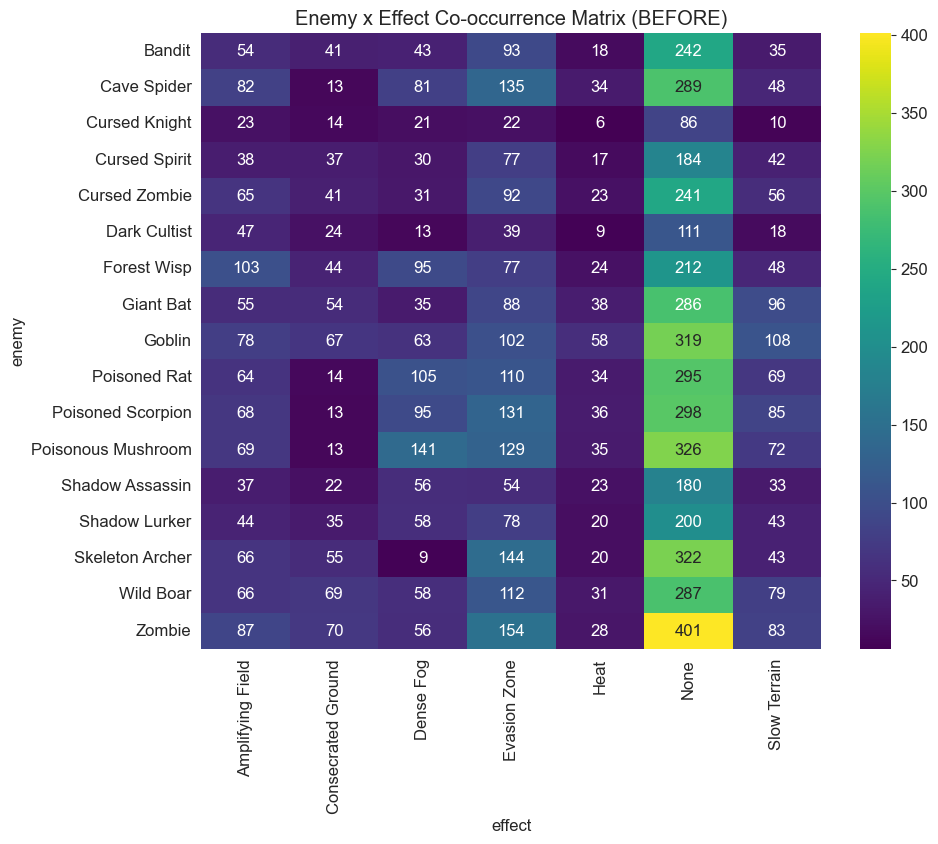

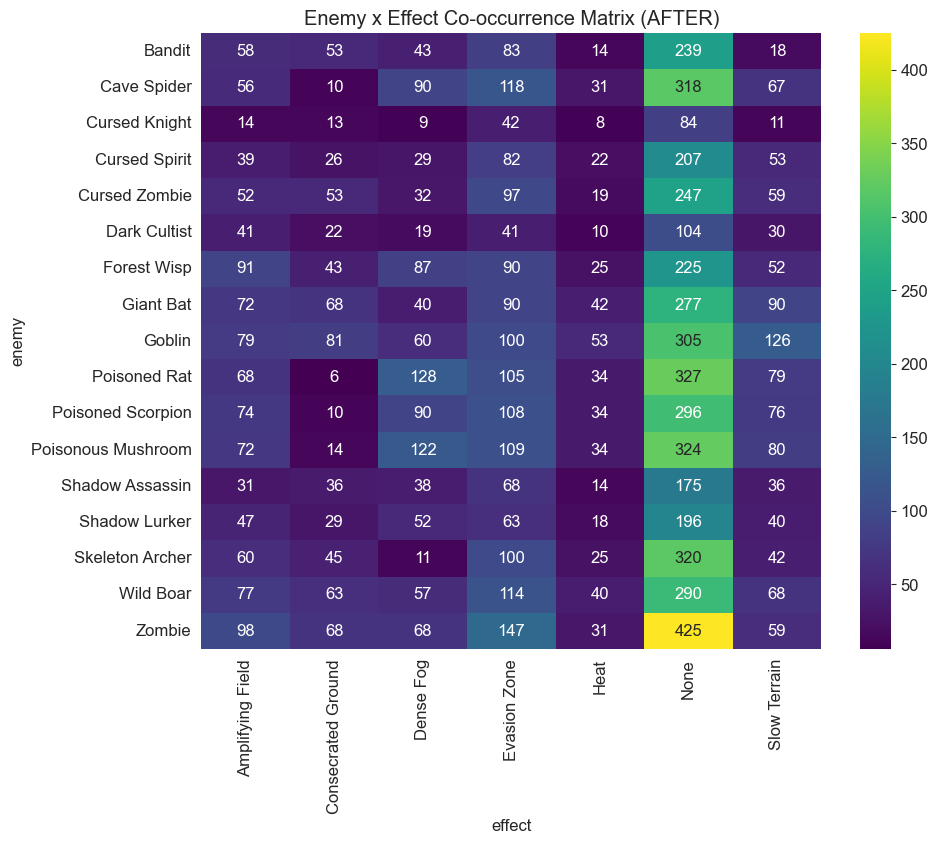



--- IMPACT CONTROL PANEL ---

                      Metric  Value BEFORE  Value AFTER  Change (%)
          Average Total Cost        9.2960       9.5129      2.3333
          Entropy H(Enemies)        4.0075       4.0064     -0.0269
          Entropy H(Effects)        2.4013       2.3909     -0.4351
Mutual Info I(Enemy; Effect)        0.0426       0.0444      4.2014


In [23]:
# Frequency Analysis for Enemies and Effects
analyze_frequency(df_before, df_after, 'enemy')
analyze_frequency(df_before, df_after, 'effect')

# Total Cost Analysis
analyze_cost(df_before, df_after)

# Co-occurrence Analysis
analyze_cooccurrence(df_before, 'BEFORE')
analyze_cooccurrence(df_after, 'AFTER')

# Quantitative Summary Calculation and Presentation
metrics_before = calculate_info_metrics(df_before, 'enemy', 'effect')
metrics_after = calculate_info_metrics(df_after, 'enemy', 'effect')

summary = pd.DataFrame({
    'Metric': ['Average Total Cost', 'Entropy H(Enemies)', 'Entropy H(Effects)', 'Mutual Info I(Enemy; Effect)'],
    'Value BEFORE': [
        df_before['total_cost'].mean(),
        metrics_before['H(col1)'],
        metrics_before['H(col2)'],
        metrics_before['I(col1;col2)']
    ],
    'Value AFTER': [
        df_after['total_cost'].mean(),
        metrics_after['H(col1)'],
        metrics_after['H(col2)'],
        metrics_after['I(col1;col2)']
    ]
})

summary['Change (%)'] = ((summary['Value AFTER'] / summary['Value BEFORE']) - 1) * 100

print("\n\n--- IMPACT CONTROL PANEL ---\n")
print(summary.to_string(index=False, float_format="%.4f"))

### 8 - Treasure Events

In [43]:
# Cria os "pools de loot" baseados na raridade
loot_pools = {
    'Common': [],
    'Rare': [],
    'Epic': [],
    'Legendary': []
}

for item_name, item_attributes in EQUIPMENT_CATALOG.items():
    rarity = item_attributes.get('rarity')
    if rarity in loot_pools:
        loot_pools[rarity].append(item_name)

loot_pools

{'Common': ['Shortsword',
  'Rusty Dagger',
  'Wooden Club',
  'Hunting Spear',
  'Iron Sword',
  'Leather Tunic',
  'Padded Vest',
  'Worn Cloak',
  'Chain Shirt',
  'Traveler’s Coat',
  'Amulet of Vigor',
  'Ring of Focus',
  'Old Charm',
  'Traveler’s Trinket',
  'Wooden Idol'],
 'Rare': ['Battle Axe',
  'Warhammer',
  'Twin Daggers',
  'Elven Bow',
  'Serrated Blade',
  'Steel Plate',
  'Knight’s Mail',
  'Scaled Vest',
  'Hunter’s Mantle',
  'Blessed Robes',
  'Tome of Haste',
  'Pendant of Will',
  'Obsidian Eye',
  'Sigil of Flame',
  'Cursed Locket'],
 'Epic': ['Mace of Stunning',
  'Dragonfang Blade',
  'Arcane Pike',
  'Flamebrand',
  'Stormcaller Blade',
  'Thornmail',
  'Guardian Shell',
  'Mirrorplate',
  'Mantle of the Phoenix',
  'Stoneshield Armor',
  "Poisoner's Talisman",
  'Orb of Decay',
  'Eye of the Storm',
  'Relic of Blood',
  'Moonstone Prism'],
 'Legendary': ['Blade of the Martyr',
  'Sword of the Forgotten King',
  'Shadowfang',
  'Ragnar’s Wrath',
  'Celesti

In [26]:
def open_treasure_chest(chest_type, loot_pools):
    """
    Sorteia um item com base no tipo de baú.
    Retorna o nome do item sorteado.
    """
    if chest_type == 'Treasure':
        # Para um baú comum, as chances são maiores para itens comuns e raros.
        rarities = ['Common', 'Rare', 'Epic', 'Legendary']
        probabilities = [0.70, 0.25, 0.04, 0.01] # 70% Comum, 25% Raro, 4% Épico, 1% Lendário

    elif chest_type == 'Morbid Treasure':
        # Para um baú mórbido, as chances de itens melhores são maiores.
        rarities = ['Common', 'Rare', 'Epic', 'Legendary']
        probabilities = [0.10, 0.50, 0.35, 0.05] # 10% Comum, 50% Raro, 35% Épico, 5% Lendário
    
    else:
        return None # Caso o tipo de baú seja desconhecido

    # 1. Sorteia a raridade do item
    chosen_rarity = np.random.choice(rarities, p=probabilities)
    
    # 2. Sorteia um item aleatório daquele pool de raridade
    if loot_pools[chosen_rarity]:
        chosen_item = np.random.choice(loot_pools[chosen_rarity])
        return chosen_item
    else:
        # Caso não haja itens da raridade sorteada, retorna um item comum como fallback
        return np.random.choice(loot_pools['Common'])

In [41]:
# Exemplo de uso
k = 4 # Andar atual
room_content = generate_room_content(k, POOLS, RULES)

event_type = room_content.get('event')

if event_type == 'Treasure' or event_type == 'Morbid Treasure':
    
    looted_item = open_treasure_chest(event_type, loot_pools)
    print(f"Você abriu um '{event_type}' e encontrou: {looted_item}!")    

Você abriu um 'Treasure' e encontrou: Leather Tunic!


### 9 - Statistical Analysis on Treasure Events

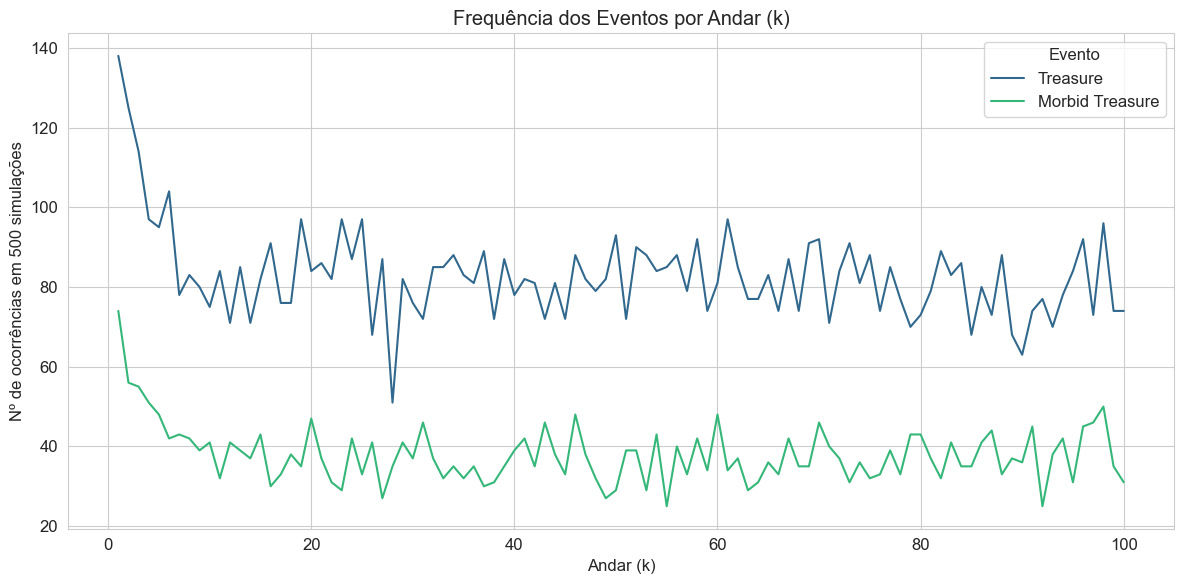

In [48]:
from collections import defaultdict

# Parâmetros
simulacoes_por_k = 500  # Por andar k
k_range = range(1, 101)  # k de 1 a 100

resultados = defaultdict(lambda: {'Treasure': 0, 'Morbid Treasure': 0})

for k in k_range:
    for _ in range(simulacoes_por_k):
        room_content = generate_room_content(k, POOLS, RULES)
        event_type = room_content.get('event')
        if event_type in ['Treasure', 'Morbid Treasure']:
            resultados[k][event_type] += 1

# Convertendo em dataframe
dados = pd.DataFrame([
    {'k': k, 'event_type': 'Treasure', 'count': resultados[k]['Treasure']} for k in k_range
] + [
    {'k': k, 'event_type': 'Morbid Treasure', 'count': resultados[k]['Morbid Treasure']} for k in k_range
])

# Gráfico de linhas
plt.figure(figsize=(12, 6))
sns.lineplot(data=dados, x='k', y='count', hue='event_type', palette='viridis')
plt.title('Frequência dos Eventos por Andar (k)')
plt.xlabel('Andar (k)')
plt.ylabel(f'Nº de ocorrências em {simulacoes_por_k} simulações')
plt.grid(True)
plt.legend(title='Evento')
plt.tight_layout()
plt.show()
